In [2]:
# Step 1. Update the PATH env var. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/student/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.10/site-packages"
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [3]:
# Check the version of any specific package
!python -m pip freeze | grep numpy

numpy @ file:///work/mkl/numpy_and_numpy_base_1682953417311/work


In [7]:
!pip -q install .

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import matplotlib.pyplot as plt


In [2]:
n_device = torch.cuda.current_device()
torch.cuda.get_device_name(n_device)

'Tesla T4'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

Found path: /data/Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/data/Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/data/Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [28]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

###  Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [29]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Take Random Actions in the Environment



In [22]:

for i in range(2):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    count = 0

    while True:
        count += 1
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        #Buffer.push(state, action, reward, next_state, done)

        state = next_state                             # roll over the state to next time step
        
        if done:                                       # exit loop if episode finished
            break

    print("Score: {}".format(score))
    print(count)

Score: 0.0
300
Score: 2.0
300


When finished, you can close the environment.

In [10]:
#env.close()

### Module

In [16]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        # Instantiate the first hidden layer
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # Instantiate the output layer
        self.fc3 = nn.Linear(fc2_units, action_size)
    def forward(self, state):
        # Ensure the ReLU activation function is used
        x = torch.relu(self.fc1(torch.tensor(state)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
def create_target_network_and_online_network(state_size, action_size, device):
    """
    Creates and initializes the target and online networks.
    
    Params
    ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        device (torch.device): Device on which to place the networks (CPU or GPU)
    
    Returns
    =======
        target_network (QNetwork): The target network
        online_network (QNetwork): The online network
    """
    # Create the online and target networks
    online_network = QNetwork(state_size, action_size).to(device)
    target_network = QNetwork(state_size, action_size).to(device)
    
    # Synchronize the target network with the online network
    target_network.load_state_dict(online_network.state_dict())
    
    return target_network, online_network

In [18]:
def select_action(q_values, step, start, end, decay):
    # Calculate the threshold value for this step
    epsilon = end + (start - end) * math.exp(-step / decay)
    # Draw a random number between 0 and 1
    sample = random.random()
    if sample < epsilon:
        # Return a random action index
        return random.choice(range(len(q_values)))
    # Return the action index with highest Q-value
    return torch.argmax(q_values).item()

In [19]:
def update_target_network(target_network, online_network, tau):
    # Obtain the state dicts for both networks
    target_net_state_dict = target_network.state_dict()
    online_net_state_dict = online_network.state_dict()
    for key in online_net_state_dict:
        # Calculate the updated state dict for the target network
        target_net_state_dict[key] = (online_net_state_dict[key] * tau + target_net_state_dict[key] * (1-tau))
        # Load the updated state dict into the target network
        target_network.load_state_dict(target_net_state_dict)
    return None

In [20]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        experience_tuple = (state, action, reward, next_state, done)
        # Append experience_tuple to the memory buffer
        self.memory.append(experience_tuple)    
    def __len__(self):
        return len(self.memory)
    def sample(self, batch_size):
        # Draw a random sample of size batch_size
        batch = random.sample(self.memory, batch_size)
        # Transform batch into a tuple of lists
        states, actions, rewards, next_states, dones = (zip(*batch))
        
        states =  np.array([torch.tensor(s).cpu().numpy() for s in states])
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array([torch.tensor(ns).cpu().numpy() for ns in next_states])
        dones = np.array(dones)
        
        
        
        states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32).to(device)
        # Ensure actions_tensor has shape (batch_size, 1)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

In [32]:
def DDQN(n_episodes, batch_size=64, gamma=0.98, lr=5e-4, start=.9, end=.05, decay=800):
    optimizer = optim.Adam(online_network.parameters(), lr=lr)
    total_steps = 0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        state = torch.from_numpy(state).float().to(device)
        episode_reward = 0
        while True:
            total_steps += 1
            q_values = online_network(state)
            # Select the action with epsilon greediness
            action = select_action(q_values, total_steps, start=start, end=end, decay=decay)

            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            next_state = torch.from_numpy(next_state).float().to(device)
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
                
                q_values = online_network(states).gather(1, actions).squeeze(1)
                
                # Ensure gradients are not tracked
                with torch.no_grad():
                    # Obtain the next state Q-values using Double DQN
                    next_actions = online_network(next_states).argmax(1).unsqueeze(1)
                    next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)
                    
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update the target network weights using soft update
                update_target_network(target_network, online_network, tau=.005)
            
            state = next_state
            episode_reward += reward
            if done:  # exit loop if episode finished
                break

        scores_window.append(episode_reward)  # save most recent episode reward
        scores.append(episode_reward)         # save most recent episode reward

        # Print episode statistics
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tepisode_reward: {episode_reward}', end="")
        if i_episode % 100 == 0:
            torch.save(online_network.state_dict(), 'ddqn_online_model.pth')
            torch.save(target_network.state_dict(), 'ddqn_target_model.pth')
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tepisode_reward: {episode_reward}')
        
        if np.mean(scores_window) >= 13:
            break
            
    torch.save(online_network.state_dict(), 'ddqn_online_model.pth')
    torch.save(target_network.state_dict(), 'ddqn_target_model.pth')

    return scores


In [22]:
target_network, online_network = create_target_network_and_online_network(state_size, action_size, device)
replay_buffer = ReplayBuffer(10000) # Maximum Steps = 300  with  episodes 30 , 300*30 = 9000

In [ ]:
#online_network.load_state_dict(torch.load('ddqn_online_model.pth'))
#target_network.load_state_dict(torch.load('ddqn_target_model.pth'))

In [33]:
scores = DDQN(2000)

/tmp/ipykernel_46/1848745818.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))
/tmp/ipykernel_46/3132154956.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states =  np.array([torch.tensor(s).cpu().numpy() for s in states])
/tmp/ipykernel_46/3132154956.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = np.array([torch.tensor(ns).cpu().numpy() for ns in next_states])


Episode 0	Average Score: 17.00	episode_reward: 17.0
Episode 100	Average Score: 11.78	episode_reward: 16.0
Episode 200	Average Score: 11.53	episode_reward: 8.00
Episode 300	Average Score: 11.14	episode_reward: 14.0
Episode 400	Average Score: 12.35	episode_reward: 13.0
Episode 500	Average Score: 12.09	episode_reward: 18.0
Episode 600	Average Score: 12.67	episode_reward: 13.0
Episode 659	Average Score: 13.02	episode_reward: 19.0

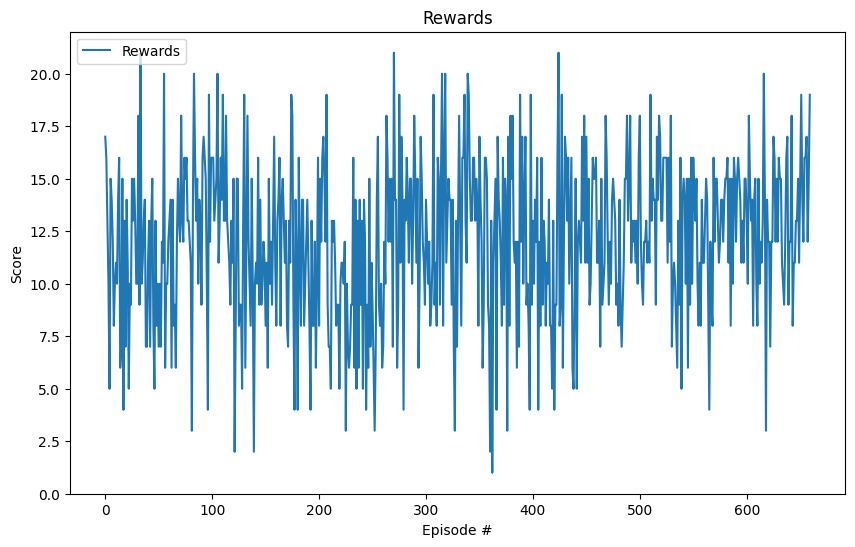

In [38]:
import matplotlib.pyplot as plt

def plot_scores(scores, filename="rewards_plot.png"):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Rewards")
    plt.xlabel("Episode #")
    plt.ylabel("Score")
    plt.title("Rewards")
    plt.legend(loc="upper left")
    #plt.grid(True)
    plt.savefig(filename)  # Save the plot as a PNG file
    #plt.close()  # Close the figure to free up memory

# Assuming 'scores' is already populated with the results of the training
plot_scores(scores)
